# Лабораторная работа №7. Решение ОДУ (обыкновенных дифференциальных уравнений) неявными методами

Рассмотрим жёсткую систему дифференциальных уравнений модели Филда-Нойса (орегонатор)


\begin{cases}
    x_1' = 77.27 \cdot (x_2 + x_1 (1 - 8.375 \cdot 10^{-6} x_1 - x_2)) \\
    x_2' = \frac{1}{77.27} \cdot (x_3 - (1 + x_1) x_2) \\
    x_3' = 0.161 \cdot (x_1 - x_3).
\end{cases}


Решим её с помощью неявного метода Гира 3-его порядка, разрешая на каждом шаге нелинейную систему
уравнений методом Ньютона:

\begin{cases}
\vec{x}_{n + 3} - \frac{18}{11} \vec{x}_{n + 2} + \frac{9}{11} \vec{x}_{n + 1} -
\frac{2}{11} \vec{x}_{n} = \frac{6h}{11} \vec{f}(t_{n + 3}, \vec{x}_{n + 3}).
\end{cases}


In [1]:
import statistics
import matplotlib
import math
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker   import MaxNLocator, ScalarFormatter, FixedFormatter

In [8]:
class NonlinearSystem:
    def __init__(self, get_jacobian, get_sys_eq):
        self.get_jacobian = get_jacobian
        self.get_sys_eq = get_sys_eq
        self.is_solved = False

    def solver(self, initial_vector, stop_iter_epsilon):
        n_iters = 0
        vector_k_next = np.copy(initial_vector)
        vector_k = np.copy(initial_vector) + np.ones(len(initial_vector)) * 2 * stop_iter_epsilon # ||x_k - x_k_next|| > stop_iter_epsilon
        while np.abs(np.linalg.norm(vector_k, ord=inf) - np.linalg.norm(vector_k_next, ord=inf)) > stop_iter_epsilon and \
            n_iters <= 30000:
            vector_k = np.copy(vector_k_next)
            vector_k_next = vector_k - np.dot(np.linalg.inv(self.get_jacobian(vector_k)), self.get_sys_eq(vector_k))
            n_iters += 1
        self.is_solved = True
        return vector_k_next, n_iters

def solver_diff(h_step, t_start, t_end, x0_vec, diff_function, method):
    assert(t_start <= t_end)
    assert(h_step > 0)

    n_steps = int((t_end - t_start) / h_step) + 1
    t = np.linspace(t_start, t_end, n_steps)

    x_vec = np.zeros((n_steps, np.shape(x0_vec)[0]))
    for i in range(np.shape(x0_vec)[0]):
        x_vec[0][i] = x0_vec[i]

    return method(h_step, t, x_vec, diff_function)

In [9]:
def func(t, x_vec):
    return np.array([77.27 * (x_vec[1] + x_vec[0] * (1 - 8.375 * 10 ** (-6) * x_vec[0] - x_vec[1])), \
                     1.0 / 77.27 * (x_vec[2]  - (1 + x_vec[0]) * x_vec[1]), \
                     0.161 * (x_vec[0] - x_vec[2])])

def get_jacobian(x_vec):
    return np.array([[77.27 * (1 - x_vec[0] * 2 * 8.375 * 10 ** (-6) - x_vec[1]), \
                      77.27 * (1 - x_vec[0]), 0], \
                      [-1/77.27 * x_vec[1], 1 / 77.27 * (-1 - x_vec[0]), 1 / 77.27], \
                      [0.161, 0, -0.161]])

def get_Gear_jacobian_func(h_step, get_jacobian_func, x_vec):
    return lambda x: np.eye(np.shape(x_vec)[0]) - 6 * h_step / 11 * get_jacobian_func(x)

def get_Gear_sys_equation_func(h_step, function, x_vec, t, x_free_vec):
    return lambda x: x - 6 * h_step / 11 * func(t, x) + x_free_vec

def method_Gear_3d_order(h_step, t, x_vec, diff_function):
    n_steps = np.shape(x_vec)[0]

    f_vec = np.zeros((n_steps, np.shape(x_vec[0])[0]))

    f_vec[0] = diff_function(t[0], x_vec[0])
    x_vec[1] = x_vec[0] + h_step * f_vec[0]

    f_vec[1] = diff_function(t[1], x_vec[1])
    x_vec[2] = x_vec[1] + h_step * f_vec[1]

    f_vec[2] = diff_function(t[2], x_vec[2])

    for j in range(3, np.shape(t)[0]):
        x_free_vec = -18 / 11 * x_vec[j - 1] + 9 / 11 * x_vec[j - 2] - 2 / 11 * x_vec[j - 3]
        x_start_vec = x_vec[j - 1] + h_step * (23 / 12 * f_vec[j - 1] - 16 / 12 * f_vec[j - 2] + 5 / 12 * f_vec[j - 2])
        system = NonlinearSystem(get_Gear_jacobian_func(h_step, get_jacobian, x_vec[j]), get_Gear_sys_equation_func(h_step, diff_function, x_vec[j], t[j], x_free_vec))
        x_vec[j], n_iters = system.solver(x_start_vec, 1e-6)
        f_vec[j] = diff_function(t[j], x_vec[j])

    return t, x_vec

def get_Euler_jacobian_func(h_step, get_jacobian_func, x_vec):
    return lambda x: np.eye(np.shape(x_vec)[0]) - h_step * get_jacobian_func(x)

def get_Euler_sys_equation_func(h_step, function, x_vec, t, x_free_vec):
    return lambda x: x - h_step * func(t, x) + x_free_vec

In [7]:
def create_axis(axes):
    axes.xaxis.set_major_locator(MaxNLocator(10))
    axes.minorticks_on()
    axes.grid(which='major', linewidth=2, color='#919191')
    axes.grid(which='minor', linestyle=':')

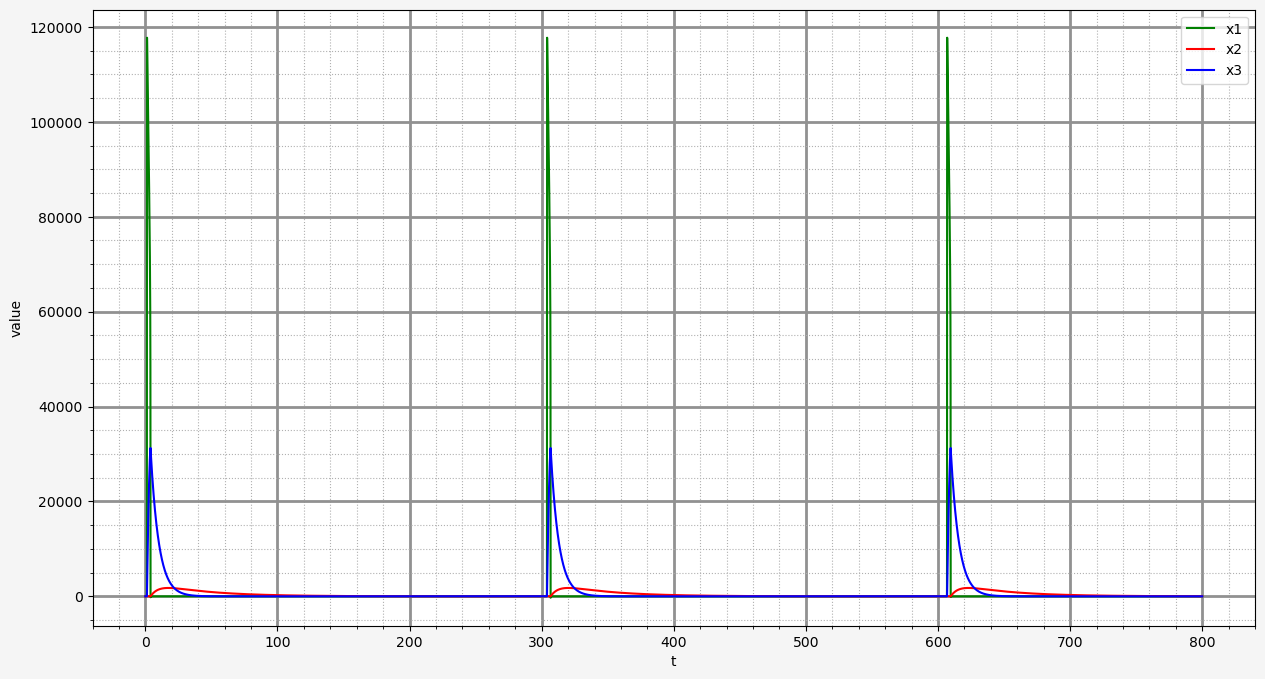

In [6]:
t_step, solution_vec = \
    solver_diff(0.01, 0, 800, np.array([4, 1.1, 4]), func, method_Gear_3d_order)

figure = plt.figure(figsize=(15, 8), facecolor='#F5F5F5')
gs = GridSpec(ncols=1, nrows=1, figure=figure)
axes = figure.add_subplot(gs[0, 0])
create_axis(axes)

x1 = np.array([solution_vec[i][0] for i in range(np.shape(solution_vec)[0])])
x2 = np.array([solution_vec[i][1] for i in range(np.shape(solution_vec)[0])])
x3 = np.array([solution_vec[i][2] for i in range(np.shape(solution_vec)[0])])

axes.plot(t_step, x1, c='g', label='x1')
axes.plot(t_step, x2, c='r', label='x2')
axes.plot(t_step, x3, c='b', label='x3')

axes.legend()
axes.set_xlabel('t')
axes.set_ylabel('value')

plt.show()


В результате получим следующее решение при начальных условиях, близких к нулю (см выше).